# 2IA - Deep Learning in Action

Music genre classification.
18 oct. 2022.

## FMA: A Dataset For Music Analysis

Michaël Defferrard, Kirell Benzi, Pierre Vandergheynst, Xavier Bresson, EPFL LTS2.

original code at <https://github.com/mdeff/fma>.



[paper]: https://arxiv.org/abs/1612.01840

## Importations

In [ ]:
%matplotlib inline

import os

import IPython.display as ipd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as skl
import sklearn.utils, sklearn.preprocessing, sklearn.decomposition, sklearn.svm
import ast
import numpy as np


import librosa
import librosa.display

plt.rcParams['figure.figsize'] = (17, 5)

from torch.utils.data import TensorDataset, DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision import models
import torch.nn.functional as F
import torchaudio
import torch
import torch.nn as nn


### Load data files and unzip

Click on the following link to obtain the small audio data zip file: [https://drive.google.com/file/d/1Rz4zzTYiBAQgtWE49A0IFp9zcy66zjSy/view?usp=sharing](https://drive.google.com/file/d/1Rz4zzTYiBAQgtWE49A0IFp9zcy66zjSy/view?usp=sharing).

On the google drive page, click on the "Add shortcut to my drive" icon (top-right of the window.) 

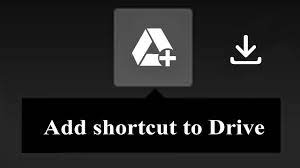

Move the shortcut on a place of your choice on your google drive. 

Repeat the same proces for the metadata zip file: [https://drive.google.com/file/d/1R0NdRo_KFiTrElv_7_u_KGbcZaLZjX5b/view?usp=sharing](https://drive.google.com/file/d/1R0NdRo_KFiTrElv_7_u_KGbcZaLZjX5b/view?usp=sharing)



In [ ]:
from google.colab import drive

drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
# Change these paths according to your google drive directories.
audio_data_path = "/content/gdrive/MyDrive/Datasets/fma_small.zip"
metadata_path = "/content/gdrive/MyDrive/Datasets/fma_metadata.zip"

In [ ]:
from zipfile import ZipFile

with ZipFile(audio_data_path, 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall()

with ZipFile(metadata_path, 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall()

In [ ]:
#AUDIO_DIR = "/content/gdrive/MyDrive/Datasets/fma_small"
AUDIO_DIR = "fma_small"
METADATA_DIR = "fma_metadata"

In [ ]:
# Load function (from https://github.com/mdeff/fma)
import os
import pandas as pd
import ast

def load(filepath):

    filename = os.path.basename(filepath)

    if 'features' in filename:
        return pd.read_csv(filepath, index_col=0, header=[0, 1, 2])

    if 'echonest' in filename:
        return pd.read_csv(filepath, index_col=0, header=[0, 1, 2])

    if 'genres' in filename:
        return pd.read_csv(filepath, index_col=0)

    if 'tracks' in filename:
        tracks = pd.read_csv(filepath, index_col=0, header=[0, 1])

        COLUMNS = [('track', 'tags'), ('album', 'tags'), ('artist', 'tags'),
                   ('track', 'genres'), ('track', 'genres_all')]
        for column in COLUMNS:
            tracks[column] = tracks[column].map(ast.literal_eval)

        COLUMNS = [('track', 'date_created'), ('track', 'date_recorded'),
                   ('album', 'date_created'), ('album', 'date_released'),
                   ('artist', 'date_created'), ('artist', 'active_year_begin'),
                   ('artist', 'active_year_end')]
        for column in COLUMNS:
            tracks[column] = pd.to_datetime(tracks[column])

        SUBSETS = ('small', 'medium', 'large')
        try:
            tracks['set', 'subset'] = tracks['set', 'subset'].astype(
                    'category', categories=SUBSETS, ordered=True)
        except (ValueError, TypeError):
            # the categories and ordered arguments were removed in pandas 0.25
            tracks['set', 'subset'] = tracks['set', 'subset'].astype(
                     pd.CategoricalDtype(categories=SUBSETS, ordered=True))
            
        return tracks

In [ ]:
# Load metadata and features.
tracks = load(METADATA_DIR + os.sep + 'tracks.csv')
genres = load(METADATA_DIR + os.sep + 'genres.csv')
features = load(METADATA_DIR + os.sep + 'features.csv')
echonest = load(METADATA_DIR + os.sep + 'echonest.csv')

np.testing.assert_array_equal(features.index, tracks.index)
assert echonest.index.isin(tracks.index).all()

tracks.shape, genres.shape, features.shape, echonest.shape

((106574, 52), (163, 4), (106574, 518), (13129, 249))

Remove bad files from their indexes.
See [https://github.com/mdeff/fma/wiki](https://github.com/mdeff/fma/wiki)

In [ ]:
bad_file_indexes = [98565, 98567, 98569, 99134, 108925, 133297] # files with very short audio length

tracks = load('fma_metadata/tracks.csv')

print("tracks.shape: ", tracks.shape)
for idx in bad_file_indexes:
  tracks = tracks.drop(idx)
print("tracks.shape after deletion: ", tracks.shape)

tracks.shape:  (106574, 52)
tracks.shape after deletion:  (106568, 52)


## Metadata

The metadata table, a CSV file in the `fma_metadata.zip` archive, is composed of many colums:
1. The index is the ID of the song, taken from the website, used as the name of the audio file.
2. Per-track, per-album and per-artist metadata from the Free Music Archive website.
3. Two columns to indicate the subset (small, medium, large) and the split (training, validation, test).

In [ ]:
print('Track:')
ipd.display(tracks['track'].head())
print('Album:')
ipd.display(tracks['album'].head())
print('Artist:')
ipd.display(tracks['artist'].head())
print('Set:')
ipd.display(tracks['set'].head())

Track:


bit_rate  comments   composer        date_created date_recorded  \
track_id                                                                    
2           256000         0        NaN 2008-11-26 01:48:12    2008-11-26   
3           256000         0        NaN 2008-11-26 01:48:14    2008-11-26   
5           256000         0        NaN 2008-11-26 01:48:20    2008-11-26   
10          192000         0  Kurt Vile 2008-11-25 17:49:06    2008-11-26   
20          256000         0        NaN 2008-11-26 01:48:56    2008-01-01   

          duration  favorites genre_top     genres         genres_all  \
track_id                                                                
2              168          2   Hip-Hop       [21]               [21]   
3              237          1   Hip-Hop       [21]               [21]   
5              206          6   Hip-Hop       [21]               [21]   
10             161        178       Pop       [10]               [10]   
20             311          0       NaN  [76, 103]  [17, 10, 76, 103]   

         information  interest language_code  \
track_id                                       
2                NaN      4656            en   
3                NaN      1470            en   
5                NaN      1933            en   
10               NaN     54881            en   
20               NaN       978            en   

                                                    license  listens lyricist  \
track_id                                                                        
2         Attribution-NonCommercial-ShareAlike 3.0 Inter...     1293      NaN   
3         Attribution-NonCommercial-ShareAlike 3.0 Inter...      514      NaN   
5         Attribution-NonCommercial-ShareAlike 3.0 Inter...     1151      NaN   
10        Attribution-NonCommercial-NoDerivatives (aka M...    50135      NaN   
20        Attribution-NonCommercial-NoDerivatives (aka M...      361      NaN   

          number publisher tags            title  
track_id                                          
2              3       NaN   []             Food  
3              4       NaN   []     Electric Ave  
5              6       NaN   []       This World  
10             1       NaN   []          Freeway  
20             3       NaN   []  Spiritual Level

Album:


comments        date_created date_released engineer  favorites  id  \
track_id                                                                       
2                0 2008-11-26 01:44:45    2009-01-05      NaN          4   1   
3                0 2008-11-26 01:44:45    2009-01-05      NaN          4   1   
5                0 2008-11-26 01:44:45    2009-01-05      NaN          4   1   
10               0 2008-11-26 01:45:08    2008-02-06      NaN          4   6   
20               0 2008-11-26 01:45:05    2009-01-06      NaN          2   4   

                                        information  listens producer tags  \
track_id                                                                     
2                                           <p></p>     6073      NaN   []   
3                                           <p></p>     6073      NaN   []   
5                                           <p></p>     6073      NaN   []   
10                                              NaN    47632      NaN   []   
20        <p> "spiritual songs" from Nicky Cook</p>     2710      NaN   []   

                         title  tracks   type  
track_id                                       
2         AWOL - A Way Of Life       7  Album  
3         AWOL - A Way Of Life       7  Album  
5         AWOL - A Way Of Life       7  Album  
10           Constant Hitmaker       2  Album  
20                       Niris      13  Album

Artist:


active_year_begin active_year_end  \
track_id                                     
2               2006-01-01             NaT   
3               2006-01-01             NaT   
5               2006-01-01             NaT   
10                     NaT             NaT   
20              1990-01-01      2011-01-01   

                                          associated_labels  \
track_id                                                      
2                                                       NaN   
3                                                       NaN   
5                                                       NaN   
10        Mexican Summer, Richie Records, Woodsist, Skul...   
20                                                      NaN   

                                                        bio  comments  \
track_id                                                                
2         <p>A Way Of Life, A Collective of Hip-Hop from...         0   
3         <p>A Way Of Life, A Collective of Hip-Hop from...         0   
5         <p>A Way Of Life, A Collective of Hip-Hop from...         0   
10        <p><span style="font-family:Verdana, Geneva, A...         3   
20        <p>Songs written by: Nicky Cook</p>\n<p>VOCALS...         2   

                date_created  favorites  id   latitude            location  \
track_id                                                                     
2        2008-11-26 01:42:32          9   1  40.058324          New Jersey   
3        2008-11-26 01:42:32          9   1  40.058324          New Jersey   
5        2008-11-26 01:42:32          9   1  40.058324          New Jersey   
10       2008-11-26 01:42:55         74   6        NaN                 NaN   
20       2008-11-26 01:42:52         10   4  51.895927  Colchester England   

          longitude                                            members  \
track_id                                                                 
2        -74.405661  Sajje Morocco,Brownbum,ZawidaGod,Custodian of ...   
3        -74.405661  Sajje Morocco,Brownbum,ZawidaGod,Custodian of ...   
5        -74.405661  Sajje Morocco,Brownbum,ZawidaGod,Custodian of ...   
10              NaN                           Kurt Vile, the Violators   
20         0.891874                                       Nicky Cook\n   

                name                                   related_projects  \
track_id                                                                  
2               AWOL  The list of past projects is 2 long but every1...   
3               AWOL  The list of past projects is 2 long but every1...   
5               AWOL  The list of past projects is 2 long but every1...   
10         Kurt Vile                                                NaN   
20        Nicky Cook                                                NaN   

                                                       tags  \
track_id                                                      
2                                                    [awol]   
3                                                    [awol]   
5                                                    [awol]   
10                                      [philly, kurt vile]   
20        [instrumentals, experimental pop, post punk, e...   

                                          website wikipedia_page  
track_id                                                          
2         http://www.AzillionRecords.blogspot.com            NaN  
3         http://www.AzillionRecords.blogspot.com            NaN  
5         http://www.AzillionRecords.blogspot.com            NaN  
10                            http://kurtvile.com            NaN  
20                                            NaN            NaN

Set:


split  subset
track_id                  
2         training   small
3         training  medium
5         training   small
10        training   small
20        training   large

## Subsets

The small and medium subsets can be selected with the below code.

In [ ]:
small = tracks[tracks['set', 'subset'] <= 'small']
small.shape

(8000, 52)

In [ ]:
medium = tracks[tracks['set', 'subset'] <= 'medium']
medium.shape

(25000, 52)

## Genres

The genre hierarchy is stored in `genres.csv`.

In [ ]:
print('{} top-level genres'.format(len(genres['top_level'].unique())))
genres.loc[genres['top_level'].unique()].sort_values('#tracks', ascending=False)

16 top-level genres


#tracks  parent                title  top_level
genre_id                                                 
38          38154       0         Experimental         38
15          34413       0           Electronic         15
12          32923       0                 Rock         12
1235        14938       0         Instrumental       1235
10          13845       0                  Pop         10
17          12706       0                 Folk         17
21           8389       0              Hip-Hop         21
2            5271       0        International          2
4            4126       0                 Jazz          4
5            4106       0            Classical          5
9            1987       0              Country          9
20           1876       0               Spoken         20
3            1752       0                Blues          3
14           1499       0             Soul-RnB         14
8             868       0  Old-Time / Historic          8
13            730       0       Easy Listening         13

In [ ]:
genres.sort_values('#tracks').head(10)

#tracks  parent                     title  top_level
genre_id                                                      
175             0      86                 Bollywood          2
178             0       4                    Be-Bop          4
377             1      19                 Deep Funk         14
173             4      86     N. Indian Traditional          2
493             4     651             Western Swing          9
374             9      20                    Banter         20
808            12      46                     Salsa          2
174            17      86  South Indian Traditional          2
465            18      20           Musical Theater         20
176            23       2                   Pacific          2

## Features

1. Features extracted from the audio for all tracks
(data collected from the [Echonest](http://the.echonest.com/) API are not presented here).

In [ ]:
print('{1} features for {0} tracks'.format(*features.shape))
columns = ['mfcc', 'chroma_cens', 'tonnetz', 'spectral_contrast']
columns.append(['spectral_centroid', 'spectral_bandwidth', 'spectral_rolloff'])
columns.append(['rmse', 'zcr'])
for column in columns:
    ipd.display(features[column].head().style.format('{:.2f}'))

518 features for 106574 tracks


## Features like MFCCs are discriminant

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


((2000, 2), (2000,))

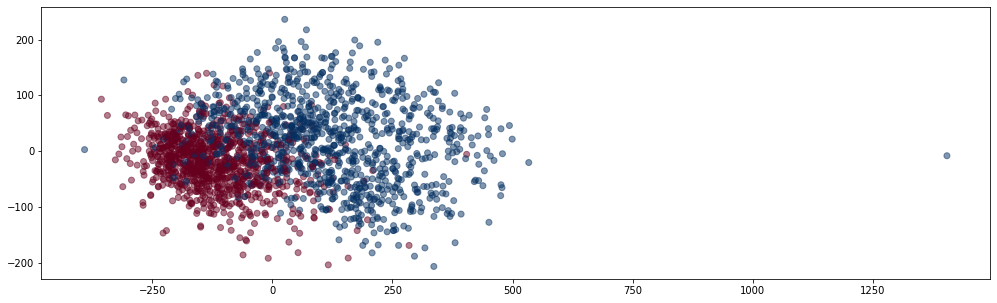

In [ ]:
small = tracks['set', 'subset'] <= 'small'

genre1 = tracks['track', 'genre_top'] == 'Instrumental'
genre2 = tracks['track', 'genre_top'] == 'Hip-Hop'

X = features.loc[small & (genre1 | genre2), 'mfcc']
X = skl.decomposition.PCA(n_components=2).fit_transform(X)

y = tracks.loc[small & (genre1 | genre2), ('track', 'genre_top')]
y = skl.preprocessing.LabelEncoder().fit_transform(y)

plt.scatter(X[:,0], X[:,1], c=y, cmap='RdBu', alpha=0.5)
X.shape, y.shape

# Genre classification

## From features

In [ ]:
small = tracks['set', 'subset'] <= 'small'

train = tracks['set', 'split'] == 'training'
val = tracks['set', 'split'] == 'validation'
test = tracks['set', 'split'] == 'test'

y_train = tracks.loc[small & train, ('track', 'genre_top')]
y_test = tracks.loc[small & test, ('track', 'genre_top')]
X_train = features.loc[small & train, 'mfcc']
X_test = features.loc[small & test, 'mfcc']

print("The small dataset contains:")
print('- {} training examples, {} testing examples'.format(y_train.size, y_test.size))
print('- {} features, {} genre categories (or classes)'.format(X_train.shape[1], np.unique(y_train).size))
print("- the folowing genre categories: ", np.unique(y_train))

The small dataset contains:
- 6400 training examples, 800 testing examples
- 140 features, 8 genre categories (or classes)
- the folowing genre categories:  ['Electronic' 'Experimental' 'Folk' 'Hip-Hop' 'Instrumental'
 'International' 'Pop' 'Rock']


In [ ]:
# Be sure training samples are shuffled.
X_train, y_train = skl.utils.shuffle(X_train, y_train, random_state=42)

# Standardize features by removing the mean and scaling to unit variance.
scaler = skl.preprocessing.StandardScaler(copy=False)
scaler.fit_transform(X_train)
scaler.transform(X_test)

# Support vector classification.
clf = skl.svm.SVC()
clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)
print('Accuracy: {:.2%}'.format(score))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.

Accuracy: 46.38%


# Audio

You can listen to the audio files at: <https://freemusicarchive.org/>.

### Load, plot and play

In [ ]:
def get_audio_path(audio_dir, track_id):
    """
    Return the path to the mp3 given the directory where the audio is stored
    and the track ID.

    Examples
    --------
    >>> get_audio_path(AUDIO_DIR, 2)
    '../data/fma_small/000/000002.mp3'

    """
    tid_str = '{:06d}'.format(track_id)
    return os.path.join(audio_dir, tid_str[:3], tid_str + '.mp3')




In [ ]:
index = 2
audio_path = get_audio_path(AUDIO_DIR, index)
print(audio_path)

fma_small/000/000002.mp3


In [ ]:
# load audio data and make melspectrogram

#waveform, sample_rate = torchaudio.load(audio_path, format="mp3") -> failed to load mp3 with torachaudio
x, sample_rate = librosa.load(audio_path, sr = None, mono = False) # -> use librosa instead
waveform = torch.tensor(x)

print("Stereo signal -> waveform shape: ", waveform.shape)
waveform = torch.mean(waveform, dim=0).unsqueeze(0) # Take only the left channel
print("Mono signal -> waveform shape: ", waveform.shape)
print("Sampling rate: ", sample_rate)

# Transforming audio files into melspectrograms
transform = transforms.Compose([torchaudio.transforms.MelSpectrogram(sample_rate=sample_rate, n_fft=4096, hop_length=4096//4), transforms.Resize((128, 1200))]) 
melspectro = transform(waveform)
print("Melspectro shape: ", melspectro.shape)

Stereo signal -> waveform shape:  torch.Size([2, 1321967])
Mono signal -> waveform shape:  torch.Size([1, 1321967])
Sampling rate:  44100
Melspectro shape:  torch.Size([1, 128, 1200])


In [ ]:
def plot_waveform(waveform, sample_rate):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
    figure.suptitle("waveform")
    plt.show(block=False)

def plot_specgram(waveform, sample_rate, title="Spectrogram"):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].specgram(waveform[c], Fs=sample_rate)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
    figure.suptitle(title)
    plt.show(block=False)


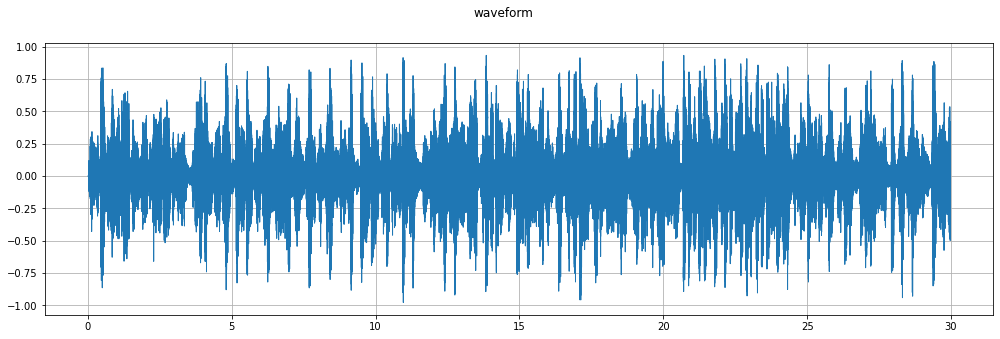

In [ ]:
plot_waveform(waveform, sample_rate)

/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_axes.py:7592: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


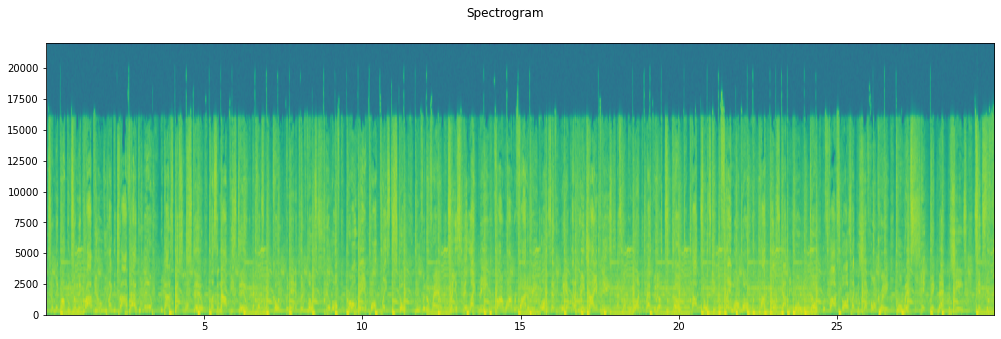

In [ ]:
plot_specgram(waveform, sample_rate)

In [ ]:
from IPython.display import Audio, display
display(Audio(waveform[0], rate=sample_rate))

In [ ]:
print("track number: ", index)
print("set: ", tracks.loc[index]["set"]["split"])
print("title: ", tracks.loc[index]["track"]["title"])
print("genre_top:  ", tracks.loc[index]["track"]["genre_top"])

track number:  2
set:  training
title:  Food
genre_top:   Hip-Hop


## Genre clasification

In [ ]:
class AudioDataset(Dataset):

  def __init__(self, audio_dir, track_ids, labels):
    super(AudioDataset, self).__init__()
    self.audio_dir = audio_dir
    self.track_ids = track_ids
    self.labels = labels

  def __len__(self):
    return len(self.track_ids)

  def __getitem__(self, index):
    audio_path = self._get_audio_path(self.audio_dir, self.track_ids[index])
    #print(index, audio_path)

    x, sample_rate = librosa.load(audio_path, sr = None, mono = False) # -> use librosa instead
    if (x.shape[0] > 2):
      waveform = torch.tensor(x[None, :])
    else:
      waveform = torch.tensor(x)

    waveform = torch.mean(waveform, dim=0).unsqueeze(0) # Take only the left channel

    # Transforming audio files into melspectrograms
    transform = transforms.Compose([torchaudio.transforms.MelSpectrogram(sample_rate=sample_rate, n_fft=4096, hop_length=4096//4), transforms.Resize((128, 1200))]) 
    melspectro = transform(waveform)

    #print("Melspectro shape: ", melspectro.shape)
    return melspectro, self.labels[self.track_ids[index]]
  
  def _get_audio_path(self, audio_dir, track_id):
    """
    Return the path to the mp3 given the directory where the audio is stored
    and the track ID.

    Examples
    --------
    >>> get_audio_path(AUDIO_DIR, 2)
    '../data/fma_small/000/000002.mp3'

    """
    tid_str = '{:06d}'.format(track_id)
    return os.path.join(audio_dir, tid_str[:3], tid_str + '.mp3')


In [ ]:
genres = tracks["track"]["genre_top"][small].unique()
genres_ids = dict(zip(genres, range(len(genres))))
genres_ids

{'Hip-Hop': 0,
 'Pop': 1,
 'Folk': 2,
 'Experimental': 3,
 'Rock': 4,
 'International': 5,
 'Electronic': 6,
 'Instrumental': 7}

In [ ]:
labels = tracks["track"]["genre_top"][small]
labels.replace(genres_ids, inplace = True)
labels.head()

track_id
2      0
5      0
10     1
140    2
141    2
Name: genre_top, dtype: int64

In [ ]:
audio_dir = AUDIO_DIR
track_ids = tracks["track"][small].index

dataset = AudioDataset(audio_dir, track_ids, labels)
len(dataset)

7994

In [ ]:
training_track_ids = tracks["track"][small][train].index
training_labels = labels[train]

test_track_ids = tracks["track"][small][test].index
test_labels = labels[test]  

training_data = AudioDataset(audio_dir, training_track_ids, training_labels)
test_data = AudioDataset(audio_dir, test_track_ids, test_labels)

In [ ]:
print(len(training_data))
print(len(test_data))

6394
800


In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=16, shuffle=True)

In [ ]:
# Define the model
class CNNNetwork(nn.Module):

    def __init__(self):
        super().__init__()
        # 4 conv blocks / flatten / linear / softmax
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3), nn.ReLU(), nn.MaxPool2d(kernel_size=2))
        self.conv2 = nn.Sequential(nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3), nn.ReLU(), nn.MaxPool2d(kernel_size=2))
        self.conv3 = nn.Sequential(nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3), nn.ReLU(), nn.MaxPool2d(kernel_size=2))
        self.conv4 = nn.Sequential(nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3), nn.ReLU(), nn.MaxPool2d(kernel_size=2))
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(128 * 6 * 73, 8)

    def forward(self, input_data):
        x = self.conv1(input_data)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.flatten(x)
        logits = self.linear(x)
        return logits

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [ ]:
train_features, train_labels = next(iter(train_dataloader))

In [ ]:
cnn = CNNNetwork()

output = cnn(train_features)
output.shape

torch.Size([16, 8])

In [ ]:
def train_test_loop(model, trainloader, testloader, epochs, log_frequency, device, learning_rate=1e-4):

  model.to(device) # we make sure the model is on the proper device

  # Multiclass classification setting, we use cross-entropy
  # note that this implementation requires the logits as input 
  # logits: values prior softmax transformation 
  loss_fn = torch.nn.CrossEntropyLoss(reduction='mean')

  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  
  for t in range(epochs):

      model.train() # we specify that we are training the model

      # At each epoch, the training set will be processed as a set of batches
      for batch_id,  batch in enumerate(trainloader) : 

        audios, labels  = batch

        # we put the data on the same device
        audios , labels = audios.to(device), labels.to(device)
        
        y_pred = model(audios) # forward pass output=logits

        loss = loss_fn(y_pred, labels)

        if batch_id % log_frequency == 0:
            print("epoch: {:03d}, batch: {:03d}, loss: {:.3f} ".format(t+1, batch_id+1, loss.item()))

        optimizer.zero_grad() # clear the gradient before backward
        loss.backward()       # update the gradient

        optimizer.step() # update the model parameters using the gradient

      # Model evaluation after each step computing the accuracy
      model.eval()
      total = 0
      correct = 0
      for batch_id, batch in enumerate(testloader):
        audios , labels = batch
        audios , labels = audios.to(device), labels.to(device)
        y_pred = model(audios) # forward computes the logits
        sf_y_pred = torch.nn.Softmax(dim=1)(y_pred) # softmax to obtain the probability distribution
        _, predicted = torch.max(sf_y_pred , 1)     # decision rule, we select the max
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
      
      print("[validation] accuracy: {:.3f}%\n".format(100 * correct / total))

#Execution avec le avg pooling
model = CNNNetwork()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
train_test_loop(model,train_dataloader, test_dataloader, epochs=3, log_frequency=10, device=device)

epoch: 001, batch: 001, loss: 259.006 
epoch: 001, batch: 011, loss: 1275.218 
epoch: 001, batch: 021, loss: 164.575 
epoch: 001, batch: 031, loss: 178.692 
epoch: 001, batch: 041, loss: 148.668 
epoch: 001, batch: 051, loss: 88.327 
epoch: 001, batch: 061, loss: 32.392 
epoch: 001, batch: 071, loss: 56.322 
epoch: 001, batch: 081, loss: 62.668 
epoch: 001, batch: 091, loss: 29.474 
epoch: 001, batch: 101, loss: 47.026 
epoch: 001, batch: 111, loss: 17.095 
epoch: 001, batch: 121, loss: 26.170 
epoch: 001, batch: 131, loss: 27.561 
epoch: 001, batch: 141, loss: 12.924 
epoch: 001, batch: 151, loss: 24.502 
epoch: 001, batch: 161, loss: 18.454 
epoch: 001, batch: 171, loss: 14.868 
epoch: 001, batch: 181, loss: 17.118 
epoch: 001, batch: 191, loss: 10.152 
epoch: 001, batch: 201, loss: 23.504 
epoch: 001, batch: 211, loss: 16.242 
epoch: 001, batch: 221, loss: 19.857 
epoch: 001, batch: 231, loss: 3.997 
epoch: 001, batch: 241, loss: 13.650 
epoch: 001, batch: 251, loss: 14.947 
epoch: 

In [ ]:
index = 4070
audio_path = get_audio_path(AUDIO_DIR, index)
print(audio_path)

x, sample_rate = librosa.load(audio_path, sr = None, mono = False) # -> use librosa instead
waveform = torch.tensor(x)
waveform = torch.mean(waveform, dim=0).unsqueeze(0)

transform = transforms.Compose([torchaudio.transforms.MelSpectrogram(sample_rate=sample_rate, n_fft=4096, hop_length=4096//4), transforms.Resize((128, 1200))]) 
melspectro = transform(waveform)

print("Melspectro shape: ", melspectro.shape)
print()

print("track number: ", index)
print("set: ", tracks.loc[index]["set"]["split"])
print("title: ", tracks.loc[index]["track"]["title"])
print("genre_top:  ", tracks.loc[index]["track"]["genre_top"])
print()

output = model(melspectro[None, :])
print("Output shape: ", output.shape)

probabilities = torch.nn.Softmax(dim=1)(output)
print("Probabilities: ", probabilities)

prediction = genres[torch.argmax(probabilities)]
print("Prédiction: ", prediction)

fma_small/004/004070.mp3
Melspectro shape:  torch.Size([1, 128, 1200])

track number:  4070
set:  training
title:  Nuevos Ojos
genre_top:   International

Output shape:  torch.Size([1, 8])
Probabilities:  tensor([[0.2885, 0.0211, 0.1812, 0.0603, 0.0240, 0.3046, 0.0876, 0.0327]],
       grad_fn=<SoftmaxBackward0>)
Prédiction:  International


In [ ]:
index = 73170
audio_path = get_audio_path(AUDIO_DIR, index)
print(audio_path)

x, sample_rate = librosa.load(audio_path, sr = None, mono = False) # -> use librosa instead
waveform = torch.tensor(x)
waveform = torch.mean(waveform, dim=0).unsqueeze(0)

transform = transforms.Compose([torchaudio.transforms.MelSpectrogram(sample_rate=sample_rate, n_fft=4096, hop_length=4096//4), transforms.Resize((128, 1200))]) 
melspectro = transform(waveform)

print("Melspectro shape: ", melspectro.shape)
print()

print("track number: ", index)
print("set: ", tracks.loc[index]["set"]["split"])
print("title: ", tracks.loc[index]["track"]["title"])
print("genre_top:  ", tracks.loc[index]["track"]["genre_top"])
print()

output = model(melspectro[None, :])
print("Output shape: ", output.shape)

probabilities = torch.nn.Softmax(dim=1)(output)
print("Probabilities: ", probabilities)

prediction = genres[torch.argmax(probabilities)]
print("Prédiction: ", prediction)

fma_small/073/073170.mp3
Melspectro shape:  torch.Size([1, 128, 1200])

track number:  73170
set:  training
title:  Greensleeves
genre_top:   Folk

Output shape:  torch.Size([1, 8])
Probabilities:  tensor([[0.0163, 0.0296, 0.2430, 0.1990, 0.0562, 0.1633, 0.0900, 0.2025]],
       grad_fn=<SoftmaxBackward0>)
Prédiction:  Folk


In [ ]:
index = 37041
audio_path = get_audio_path(AUDIO_DIR, index)
print(audio_path)

x, sample_rate = librosa.load(audio_path, sr = None, mono = False) # -> use librosa instead
waveform = torch.tensor(x)
waveform = torch.mean(waveform, dim=0).unsqueeze(0)

transform = transforms.Compose([torchaudio.transforms.MelSpectrogram(sample_rate=sample_rate, n_fft=4096, hop_length=4096//4), transforms.Resize((128, 1200))]) 
melspectro = transform(waveform)

print("Melspectro shape: ", melspectro.shape)
print()

print("track number: ", index)
print("set: ", tracks.loc[index]["set"]["split"])
print("title: ", tracks.loc[index]["track"]["title"])
print("genre_top:  ", tracks.loc[index]["track"]["genre_top"])
print()

output = model(melspectro[None, :])
print("Output shape: ", output.shape)

probabilities = torch.nn.Softmax(dim=1)(output)
print("Probabilities: ", probabilities)

prediction = genres[torch.argmax(probabilities)]
print("Prédiction: ", prediction)

fma_small/037/037041.mp3
Melspectro shape:  torch.Size([1, 128, 1200])

track number:  37041
set:  training
title:  Improvisation
genre_top:   Experimental

Output shape:  torch.Size([1, 8])
Probabilities:  tensor([[1.4003e-13, 2.3563e-07, 2.1319e-09, 1.0000e+00, 8.5490e-10, 1.5001e-10,
         2.5388e-13, 5.3195e-11]], grad_fn=<SoftmaxBackward0>)
Prédiction:  Experimental


In [ ]:
index = 88899
audio_path = get_audio_path(AUDIO_DIR, index)
print(audio_path)

x, sample_rate = librosa.load(audio_path, sr = None, mono = False) # -> use librosa instead
waveform = torch.tensor(x)
waveform = torch.mean(waveform, dim=0).unsqueeze(0)

transform = transforms.Compose([torchaudio.transforms.MelSpectrogram(sample_rate=sample_rate, n_fft=4096, hop_length=4096//4), transforms.Resize((128, 1200))]) 
melspectro = transform(waveform)

print("Melspectro shape: ", melspectro.shape)
print()

print("track number: ", index)
print("set: ", tracks.loc[index]["set"]["split"])
print("title: ", tracks.loc[index]["track"]["title"])
print("genre_top:  ", tracks.loc[index]["track"]["genre_top"])
print()

output = model(melspectro[None, :])
print("Output shape: ", output.shape)

probabilities = torch.nn.Softmax(dim=1)(output)
print("Probabilities: ", probabilities)

prediction = genres[torch.argmax(probabilities)]
print("Prédiction: ", prediction)

fma_small/088/088899.mp3
Melspectro shape:  torch.Size([1, 128, 1200])

track number:  88899
set:  training
title:  Brown, Grey, Green
genre_top:   Rock

Output shape:  torch.Size([1, 8])
Probabilities:  tensor([[0.0347, 0.0093, 0.0134, 0.5493, 0.3110, 0.0108, 0.0406, 0.0309]],
       grad_fn=<SoftmaxBackward0>)
Prédiction:  Experimental


In [ ]:
index = 134794
audio_path = get_audio_path(AUDIO_DIR, index)
print(audio_path)

x, sample_rate = librosa.load(audio_path, sr = None, mono = False) # -> use librosa instead
waveform = torch.tensor(x)
waveform = torch.mean(waveform, dim=0).unsqueeze(0)

transform = transforms.Compose([torchaudio.transforms.MelSpectrogram(sample_rate=sample_rate, n_fft=4096, hop_length=4096//4), transforms.Resize((128, 1200))]) 
melspectro = transform(waveform)

print("Melspectro shape: ", melspectro.shape)
print()

print("track number: ", index)
print("set: ", tracks.loc[index]["set"]["split"])
print("title: ", tracks.loc[index]["track"]["title"])
print("genre_top:  ", tracks.loc[index]["track"]["genre_top"])
print()

output = model(melspectro[None, :])
print("Output shape: ", output.shape)

probabilities = torch.nn.Softmax(dim=1)(output)
print("Probabilities: ", probabilities)

prediction = genres[torch.argmax(probabilities)]
print("Prédiction: ", prediction)

fma_small/134/134794.mp3
Melspectro shape:  torch.Size([1, 128, 1200])

track number:  134794
set:  test
title:  Christina
genre_top:   Instrumental

Output shape:  torch.Size([1, 8])
Probabilities:  tensor([[3.4815e-05, 6.0694e-02, 3.5624e-06, 1.8235e-05, 5.5056e-02, 9.4383e-06,
         8.7600e-05, 8.8410e-01]], grad_fn=<SoftmaxBackward0>)
Prédiction:  Instrumental
